# Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd
import os
base_path = '/content/drive/MyDrive/tobigs/Data/rs_basic/'

tags_df = pd.read_csv(os.path.join(base_path, 'tags.csv'), encoding='utf-8')
ratings_df = pd.read_csv(os.path.join(base_path, 'ratings.csv'), encoding='utf-8')
movies_df = pd.read_csv(os.path.join(base_path, 'movies.csv'), encoding='utf-8')

In [11]:
tags_df.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [12]:
ratings_df.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [13]:
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


# EDA

In [24]:
mean_rating_df = ratings_df.groupby('movieId').mean()['rating']
mean_rating_df = pd.DataFrame(mean_rating_df)
mean_rating_df.head()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


In [30]:
# 레이팅 높은 순서대로 영화 확인
rating_genre_df = mean_rating_df.merge(movies_df, on='movieId')
rating_genre_df = rating_genre_df.sort_values(by='rating', ascending=False)
rating_genre_df

,movieId,rating,title,genres
7638,88448,5.0,Paper Birds (Pájaros de papel) (2010),Comedy|Drama
8089,100556,5.0,"Act of Killing, The (2012)",Documentary
9065,143031,5.0,Jump In! (2007),Comedy|Drama|Romance
9076,143511,5.0,Human (2015),Documentary
9078,143559,5.0,L.A. Slasher (2015),Comedy|Crime|Fantasy
...,...,...,...,...
9253,157172,0.5,Wizards of the Lost Kingdom II (1989),Action|Fantasy
7536,85334,0.5,Hard Ticket to Hawaii (1987),Action|Comedy
6486,53453,0.5,Starcrash (a.k.a. Star Crash) (1978),Action|Adventure|Fantasy|Sci-Fi
5200,8494,0.5,"Cincinnati Kid, The (1965)",Drama


In [42]:
import itertools
all_genres = [x.split('|') for x in movies_df['genres'].values]
genres = list(set(list(itertools.chain(*all_genres))))

genres_dict_score = {x:0 for x in genres}
genres_dict_cnt = {x:0 for x in genres}

In [43]:
for i in range(len(rating_genre_df)):
    row = rating_genre_df.iloc[i]
    row_genres = row['genres']
    if len(row_genres) > 0:
        for genre in row_genres.split('|'):
            genres_dict_score[genre] += row['rating']
            genres_dict_cnt[genre] += 1


In [45]:
for key, value in genres_dict_score.items():
    genres_dict_score[key] = value/genres_dict_cnt[key]
genres_dict_score

{'Mystery': 3.3303636065388305,
 'Western': 3.3833889087601254,
 'Film-Noir': 3.6704709375189575,
 'Sci-Fi': 3.1026374537884083,
 'Musical': 3.2963709618468617,
 'Documentary': 3.7816816901269963,
 'Horror': 2.91896469971008,
 'War': 3.5716549384975473,
 'Romance': 3.3648703259133175,
 'Thriller': 3.156116099463019,
 'IMAX': 3.311996371092887,
 '(no genres listed)': 3.3711484593837535,
 'Action': 3.0944984491955148,
 'Crime': 3.3018438310311775,
 'Fantasy': 3.2188431253303844,
 'Drama': 3.420905347105543,
 'Adventure': 3.2152298081978454,
 'Animation': 3.4971191501287753,
 'Comedy': 3.1817162918678026,
 'Children': 3.107690360529312}

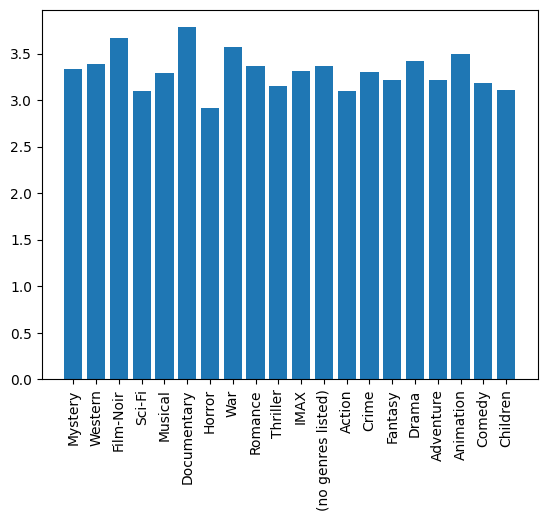

In [47]:
# 장르별 평균 레이팅 확인
import matplotlib.pyplot as plt
plt.bar(range(len(genres_dict_score)), list(genres_dict_score.values()), align='center')
plt.xticks(range(len(genres_dict_score)), list(genres_dict_score.keys()))
plt.xticks(rotation=90)

plt.show()

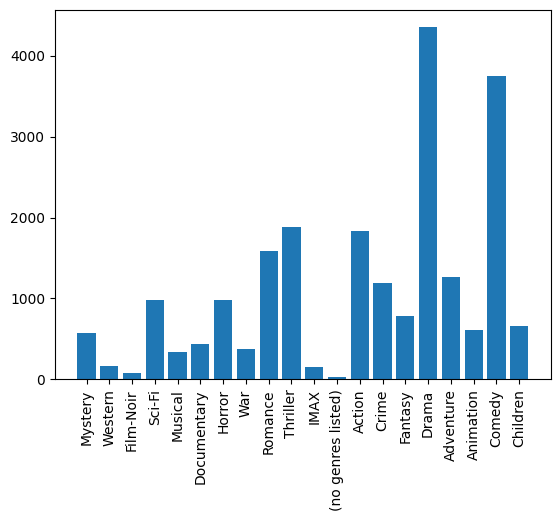

In [51]:
# 장르별 voting 개수 확인

import matplotlib.pyplot as plt
plt.bar(range(len(genres_dict_cnt)), list(genres_dict_cnt.values()), align='center')
plt.xticks(range(len(genres_dict_cnt)), list(genres_dict_cnt.keys()))
plt.xticks(rotation=90)

plt.show()

In [48]:
ratings_df.groupby('movieId')['userId'].count()

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: userId, Length: 9724, dtype: int64

In [49]:
ratings_df.groupby('movieId')['rating'].mean()

movieId
1         3.920930
2         3.431818
3         3.259615
4         2.357143
5         3.071429
            ...   
193581    4.000000
193583    3.500000
193585    3.500000
193587    3.500000
193609    4.000000
Name: rating, Length: 9724, dtype: float64

In [50]:
# 평점 평균과 평점 개수의 상관관계
rating_cnt_corr_df = pd.DataFrame({
    'rating_cnt': ratings_df.groupby('movieId')['userId'].count(),
    'rating_mean': ratings_df.groupby('movieId')['rating'].mean()
})

rating_cnt_corr_df.corr()

,rating_cnt,rating_mean
rating_cnt,1.000000,0.127259
rating_mean,0.127259,1.000000


# Recommendation System

In [132]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

df = pd.pivot(index = 'movieId',columns = 'userId', data = ratings_df, values ='rating').fillna(0)
df.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [99]:
movie_voting_cnt = pd.DataFrame(ratings_df.groupby('movieId')['rating'].agg('count'))
movie_voting_cnt.reset_index(level = 0, inplace = True)

movie_voting_cnt.head(5)

,movieId,rating
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49


In [100]:
user_voting_cnt = pd.DataFrame(ratings_df.groupby("userId")["rating"].agg("count"))
user_voting_cnt.reset_index(level = 0, inplace = True)

user_voting_cnt.head(5)

,userId,rating
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [133]:
df = df.loc[movie_voting_cnt[movie_voting_cnt["rating"] > 10]["movieId"], :]
df = df.loc[:, user_voting_cnt[user_voting_cnt["rating"] >50]["userId"]]
df

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
csr_data = csr_matrix(df.values)
df.reset_index(inplace=True)

knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
knn.fit(csr_data)
def get_movie_recommendation(movie_name):
    global df
    n= 10
    movie_list = movies_df[movies_df['title'].str.contains(movie_name)]
    if len(movie_list):
        movie_idx= movie_list.iloc[0]['movieId'] #movieId
        movie_idx = df[df['movieId'] == movie_idx].index[0] #userId acc to movieId
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n+1)
        rec_movie_indices = sorted(list(zip(indices.squeeze(),distances.squeeze())),key=lambda x: x[1])[1::1]
        recommend = []
        recommend2 = []
        for val in rec_movie_indices:
            movie_idx = df.iloc[val[0]]['movieId']
            idx = movies_df[movies_df['movieId'] == movie_idx].index
            recommend.append(movies_df.iloc[idx]['title'].values[0])
            recommend2.append(val[1])
        df1 = pd.DataFrame(recommend)
        df2 = pd.DataFrame(recommend2)
        returned_df = pd.concat([df1,df2],axis = 'columns')
        returned_df.columns = ['Title','Distance']
        returned_df.set_index('Distance',inplace = True)
        return returned_df
    else:
        return "No movies found. Please check your input"

In [135]:
get_movie_recommendation('Avengers')

,Title
Distance,
0.464465,Sphere (1998)
0.502303,"Edge, The (1997)"
0.507164,Anaconda (1997)
0.548800,William Shakespeare's A Midsummer Night's Drea...
0.563339,Snake Eyes (1998)
0.564510,Reindeer Games (2000)
0.567220,Speed 2: Cruise Control (1997)
0.568688,Mercury Rising (1998)
0.578154,"Haunting, The (1999)"
